# First steps with ReservoirPy

## Settings

In [1]:
# Name of the config
CONFIG_NAME = "config-03"

# Data setting
CSV_FILE = "../../data/synthetic_bph_1/simulation.csv"
USE_NOISY_DATA = False
USE_MIXED_EFFECT = False

# Reservoir setting
INPUT_TO_READOUT = True
READOUT_FEEDBACK_TO_RESERVOIR = True

#

## Imports

In [2]:
import sys, inspect, importlib


TOOL_PATH = "../../tools"
sys.path.append(TOOL_PATH)


def load_forked(module_name: str):
    forked_folder = "/home/francois/Documents/francois/github/" + module_name
    sys.path = [forked_folder] + sys.path
    module = importlib.import_module(module_name)
    module_path = inspect.getfile(module)
    print(f"path for module {module} is: {module_path}")
    assert module_path.startswith(forked_folder)


load_forked("reservoirpy")
load_forked("hyperopt")

path for module <module 'reservoirpy' from '/home/francois/Documents/francois/github/reservoirpy/reservoirpy/__init__.py'> is: /home/francois/Documents/francois/github/reservoirpy/reservoirpy/__init__.py
path for module <module 'hyperopt' from '/home/francois/Documents/francois/github/hyperopt/hyperopt/__init__.py'> is: /home/francois/Documents/francois/github/hyperopt/hyperopt/__init__.py


In [3]:
from math import ceil
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import TransformedTargetRegressor
from joblib import dump as jldump
from reservoirpy.nodes import Reservoir, Ridge, Input, ScikitLearnNode
from reservoirpy.observables import nrmse, rsquare
from reservoirpy.hyper import research, plot_hyperopt_report

from model_configurations import ModelConfiguration
from time_series_modules import train_test_split_on_series

## Data Loading

In [4]:
data = pd.read_csv(CSV_FILE, sep=";", decimal=",")
data

,individus,temps,x1,x1_obs,x2,x2_obs,x3,x3_obs,x4,x4_obs,...,x5_obs,x6,x6_obs,x7,x7_obs,x8,y_mixed,y_mixed_obs,y_fixed,y_fixed_obs
0,1,0,0.578900,2.609469,1.182835,1.163621,0.337061,0.425037,-0.431840,-0.357768,...,-0.232450,0.831012,1.352299,-0.516725,-0.530378,0,-0.377299,-0.446602,-0.377299,-0.485727
1,1,1,-0.722880,0.632410,1.063808,1.213479,0.336570,0.027890,-0.291742,-0.231186,...,-0.046091,1.100089,0.659184,-0.197166,-0.202305,0,-0.351356,-0.336197,-0.351356,-0.215917
2,1,2,-2.024659,-4.894554,0.994182,1.007263,0.335097,0.190370,-0.164976,-0.228072,...,-0.027549,1.406843,1.589057,-0.054419,-0.062498,0,-0.465150,-0.305957,-0.465150,-0.520721
3,1,3,-3.326438,-1.686564,0.944782,1.016037,0.332642,0.353213,-0.050273,-0.054755,...,-0.002254,1.751273,1.588178,-0.013368,-0.002160,0,-0.593820,-0.562556,-0.593820,-0.540925
4,1,4,-4.628218,-5.122320,0.906464,0.815443,0.329205,0.389886,0.053514,0.104324,...,-0.023248,2.133381,2.310414,-0.003183,-0.018556,0,-0.724237,-0.768777,-0.724237,-0.885692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25495,500,46,-23.332007,-23.355913,-4.344100,-4.414434,-0.173962,-0.122074,-1.178537,-1.380993,...,-0.005981,13.776952,13.618513,-1.257165,-1.260118,1,-14.103343,-13.962535,26.986214,26.676660
25496,500,47,-23.805504,-25.684027,-4.367756,-4.504144,-0.225636,-0.238187,-1.177882,-1.235860,...,0.009649,14.593799,14.807169,-1.257178,-1.253582,1,-14.908790,-14.811023,28.732735,28.779230
25497,500,48,-24.279001,-24.921407,-4.390925,-4.286035,-0.278421,-0.347200,-1.177290,-1.228622,...,-0.002082,15.434169,15.402741,-1.257188,-1.264389,1,-15.742044,-15.744676,30.539551,30.650900
25498,500,49,-24.752498,-24.910869,-4.413625,-4.399454,-0.332318,-0.325558,-1.176754,-1.040624,...,0.033597,16.298063,16.347750,-1.257196,-1.251337,1,-16.603254,-16.663303,32.406986,32.383627


In [5]:
SERIE_COLUMN_NAME = "individus"
TIMESTEP_COLUMN_NAME = "temps"

x_labels = [
    c for c in data.columns if c.startswith("x") and (("_obs" in c) is USE_NOISY_DATA)
]
assert len(x_labels) == 8

y_labels = [
    c
    for c in data.columns
    if c.startswith("y")
    and (("_obs" in c) is USE_NOISY_DATA)
    and (("_mixed" in c) is USE_MIXED_EFFECT)
]
assert len(y_labels) == 1

print(x_labels)
print(y_labels)

['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8']
['y_fixed']


### Spliting on series/individuals

In [6]:
TEST_TRAIN_RATIO = 0.2


data_train, data_test = train_test_split_on_series(
    data,
    SERIE_COLUMN_NAME,
    TIMESTEP_COLUMN_NAME,
    test_size=TEST_TRAIN_RATIO,
    random_state=42,
    shuffle=True,
)

Checking the "series x timesteps" hypothesis…
The dataframe has 500 unique series and 51 unique timesteps, for a total of 25500==500x51


In [7]:
data_train

,individus,temps,x1,x1_obs,x2,x2_obs,x3,x3_obs,x4,x4_obs,...,x5_obs,x6,x6_obs,x7,x7_obs,x8,y_mixed,y_mixed_obs,y_fixed,y_fixed_obs
51,2,0,0.239470,3.623647,0.689672,0.680694,0.022125,0.039108,-2.141046,-2.200175,...,0.054354,0.023946,-1.163267,-0.456192,-0.446443,1,0.726698,0.757364,0.141948,0.062496
52,2,1,0.425554,1.455243,-0.552046,-0.461030,0.021768,-0.055345,-2.015104,-2.176309,...,0.085076,0.040596,0.086850,-0.545806,-0.544588,1,0.696121,0.709414,0.175581,0.186102
53,2,2,0.611639,2.236909,-1.278405,-1.132379,0.020697,0.169975,-1.901148,-2.040687,...,0.069012,0.061617,-0.246386,-0.628761,-0.633038,1,0.666024,0.553910,0.216806,0.279733
54,2,3,0.797723,-0.224566,-1.793765,-1.756710,0.018911,-0.049667,-1.798035,-1.806280,...,0.079222,0.087006,-0.204201,-0.700240,-0.707350,1,0.639945,0.703938,0.265336,0.328670
55,2,4,0.983808,1.571825,-2.193509,-2.235005,0.016411,0.049775,-1.704736,-1.713922,...,0.084837,0.116766,0.429388,-0.758125,-0.782778,1,0.615497,0.648005,0.323249,0.377272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25495,500,46,-23.332007,-23.355913,-4.344100,-4.414434,-0.173962,-0.122074,-1.178537,-1.380993,...,-0.005981,13.776952,13.618513,-1.257165,-1.260118,1,-14.103343,-13.962535,26.986214,26.676660
25496,500,47,-23.805504,-25.684027,-4.367756,-4.504144,-0.225636,-0.238187,-1.177882,-1.235860,...,0.009649,14.593799,14.807169,-1.257178,-1.253582,1,-14.908790,-14.811023,28.732735,28.779230
25497,500,48,-24.279001,-24.921407,-4.390925,-4.286035,-0.278421,-0.347200,-1.177290,-1.228622,...,-0.002082,15.434169,15.402741,-1.257188,-1.264389,1,-15.742044,-15.744676,30.539551,30.650900
25498,500,49,-24.752498,-24.910869,-4.413625,-4.399454,-0.332318,-0.325558,-1.176754,-1.040624,...,0.033597,16.298063,16.347750,-1.257196,-1.251337,1,-16.603254,-16.663303,32.406986,32.383627


In [8]:
data_test

,individus,temps,x1,x1_obs,x2,x2_obs,x3,x3_obs,x4,x4_obs,...,x5_obs,x6,x6_obs,x7,x7_obs,x8,y_mixed,y_mixed_obs,y_fixed,y_fixed_obs
0,1,0,0.578900,2.609469,1.182835,1.163621,0.337061,0.425037,-0.431840,-0.357768,...,-0.232450,0.831012,1.352299,-0.516725,-0.530378,0,-0.377299,-0.446602,-0.377299,-0.485727
1,1,1,-0.722880,0.632410,1.063808,1.213479,0.336570,0.027890,-0.291742,-0.231186,...,-0.046091,1.100089,0.659184,-0.197166,-0.202305,0,-0.351356,-0.336197,-0.351356,-0.215917
2,1,2,-2.024659,-4.894554,0.994182,1.007263,0.335097,0.190370,-0.164976,-0.228072,...,-0.027549,1.406843,1.589057,-0.054419,-0.062498,0,-0.465150,-0.305957,-0.465150,-0.520721
3,1,3,-3.326438,-1.686564,0.944782,1.016037,0.332642,0.353213,-0.050273,-0.054755,...,-0.002254,1.751273,1.588178,-0.013368,-0.002160,0,-0.593820,-0.562556,-0.593820,-0.540925
4,1,4,-4.628218,-5.122320,0.906464,0.815443,0.329205,0.389886,0.053514,0.104324,...,-0.023248,2.133381,2.310414,-0.003183,-0.018556,0,-0.724237,-0.768777,-0.724237,-0.885692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25393,498,46,-20.042683,-22.991784,-4.305813,-4.285416,-1.008625,-0.835657,1.413129,1.469617,...,-0.000800,10.165008,9.474388,-1.667517,-1.657866,1,-15.239867,-15.123631,19.773602,19.768248
25394,498,47,-20.476856,-22.271010,-4.334574,-4.305548,-1.095560,-0.942135,1.414368,1.429053,...,-0.014008,10.415454,10.435068,-1.667517,-1.665445,1,-15.694905,-15.819743,20.391672,20.372695
25395,498,48,-20.911029,-21.861396,-4.362741,-4.556842,-1.184364,-1.133681,1.415489,1.429348,...,-0.023474,10.668949,11.156696,-1.667517,-1.655116,1,-16.157002,-16.170034,21.019332,20.926966
25396,498,49,-21.345202,-22.647592,-4.390339,-4.488709,-1.275039,-1.181088,1.416503,1.511823,...,-0.006141,10.925491,11.154988,-1.667517,-1.645091,1,-16.626182,-16.442007,21.656610,21.855821


### Data scaling and formating

In [9]:
column_order = [SERIE_COLUMN_NAME, TIMESTEP_COLUMN_NAME] + x_labels + y_labels
sort_columns = [SERIE_COLUMN_NAME, TIMESTEP_COLUMN_NAME]

In [10]:
data_train = data_train[column_order].sort_values(by=sort_columns)
N_series_train = len(data_train[SERIE_COLUMN_NAME].unique())
N_times_train = len(data_train[TIMESTEP_COLUMN_NAME].unique())

print(N_series_train, N_times_train)

400 51


In [11]:
data_test = data_test[column_order].sort_values(by=sort_columns)
N_series_test = len(data_test[SERIE_COLUMN_NAME].unique())
N_times_test = len(data_test[TIMESTEP_COLUMN_NAME].unique())

print(N_series_test, N_times_test)

100 51


In [12]:
x_train = data_train[x_labels]
y_train = data_train[y_labels]

print(x_train.shape, y_train.shape)

(20400, 8) (20400, 1)


In [13]:
x_test = data_test[x_labels]
y_test = data_test[y_labels]

print(x_test.shape, y_test.shape)

(5100, 8) (5100, 1)


### Scaling

In [14]:
x_scaler = StandardScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

In [15]:
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
# we will "inverse_transform" the prediction instead

### Reshaping

https://reservoirpy.readthedocs.io/en/latest/user_guide/quickstart.html#A-note-on-data-formats

> In ReservoirPy, all data are stored in Numpy arrays. It includes parameters of ReservoirPy Nodes and their input data. ReservoirPy uses only Numpy and Scipy for all computations.
>
> All timeseries, from input data to reservoir’s activations, are formatted the same way: they must be Numpy arrays of shape $(timesteps, features)$. For instance, a timeseries composed of two variables samples over $100$ timesteps would be stored in an array of shape $(100, 2)$. Single timesteps must also comply to this convention. A single timestep of the same 2-dimensional timeseries would be an array of shape $(1, 2)$. Make sure to always comply with this formatting otherwise you might obtain unexpected results, or raise an error.
>
> When training or running over several independent timeseries, for instance using several audio signals or several sine wave at different frequency, an accepted shape may be $(series, timesteps, features)$. In that case, input data may be an array where all series have the same length $timesteps$, or a list of arrays storing timeseries of different lengths.

In [16]:
x_train_3D = x_train_scaled.reshape([N_series_train, N_times_train, len(x_labels)])
y_train_3D = y_train_scaled.reshape([N_series_train, N_times_train, len(y_labels)])

print(x_train_3D.shape, y_train_3D.shape)

(400, 51, 8) (400, 51, 1)


In [17]:
x_test_3D = x_test_scaled.reshape([N_series_test, N_times_test, len(x_labels)])
print(x_test_3D.shape)

(100, 51, 8)


## Training a Reservoir model

**[offline training](https://reservoirpy.readthedocs.io/en/latest/user_guide/learning_rules.html#offline-learning-rules-linear-regression)**  
> parameters of the […] model are learned given all available samples of data and all available samples of target values.  

**[sequence-to-sequence](https://github.com/reservoirpy/reservoirpy/blob/master/tutorials/5-Classification-with-RC.ipynb)**
> A model is trained on encoding each vector of input sequence into a new vector in the output space. Thus, a sequence of audio yields a sequence of label, one label per timestep.  

https://reservoirpy.readthedocs.io/en/latest/user_guide/quickstart.html


> $W_{in}$ and $W$ are the inputs-to-reservoir and recurrent connections.  
> $W_{out}$ represents the trained output weights of the readout.  
> $W_{fb}$ represents the additional connections feeding the readout outputs back to the reservoir.

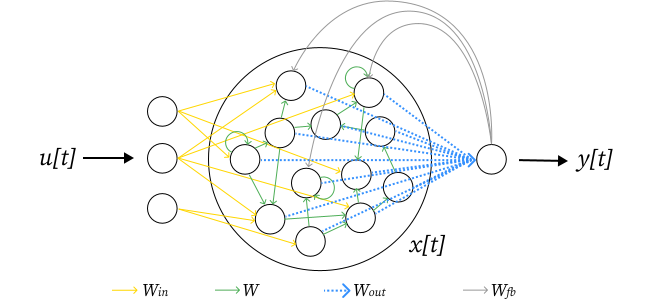


> We change the value of two hyperparameters:
> - $lr$: the leaking rate, which controls the time constant of the neurons;
> - $sr$: the spectral radius of the recurrent connections in the reservoir. It controls the chaoticity of the reservoir dynamics.


 
Pour [un exemple plus sophistiqué](https://github.com/reservoirpy/reservoirpy/blob/master/tutorials/5-Classification-with-RC.ipynb), ils utilisent:
```python
model = [source >> reservoir, source] >> readout
Y_pred = model.fit(X_train, Y_train, stateful=False, warmup=2).run(X_test, stateful=False)
```

C'est expliqué dans la [documentation avancée](https://reservoirpy.readthedocs.io/en/latest/user_guide/advanced_demo.html), où il y a aussi la commande pour utiliser les "Feedback connections":

```python
reservoir <<= readout
esn_model = reservoir >> readout
esn_model = esn_model.fit(X_train, Y_train, force_teachers=True)
Y_pred = esn_model.run(X_train, forced_feedbacks=Y_train, shift_fb=True)
```

**Remarque perso**:

Lors de la prédiction on récupère une liste de taille `series` avec des tenseurs de taille `(timesteps, target)`.
Donc avec un simple `np.array` on retrouve le tenseur attendu de taille `(series, timesteps, target)`.

 ### Overfitting test (with hyper-parameters optimisation)

 https://reservoirpy.readthedocs.io/en/latest/user_guide/hyper.html#Optimize-hyperparameters


 **Remarque perso**: comme ils utilisent un Random Search mais qu'ils veulent forcer l'utilisation de plusieurs seeds à chaquee fois (éq. à Grid Search), ils utilisent un paramètre `instances_per_trial` et une boucle `for` dans la fonction objectif. Pas de raison de changer pour l'instant…

In [18]:
def objective(
    dataset,
    config,
    *,
    input_scaling,
    N,
    sr,
    lr,
    ridge,
    seed,
    input_to_readout,
    readout_feedback_to_reservoir,
    warmup
):
    # This step may vary depending on what you put inside 'dataset'
    x_train, y_train, x_test, y_test = dataset

    # You can access anything you put in the config
    # file from the 'config' parameter.
    instances = config["instances_per_trial"]

    # The seed should be changed across the instances,
    # to be sure there is no bias in the results
    # due to initialization.
    variable_seed = seed

    losses = []
    r2s = []
    for variable_seed in range(instances):
        # Build your model given the input parameters
        input_kwargs = {}
        reservoir_kwargs = {
            "units": N,
            "lr": lr,
            "sr": sr,
            "input_scaling": input_scaling,
            "seed": variable_seed,
        }
        ridge_kwargs = {"ridge": ridge}
        fit_kwargs = {"warmup": warmup}

        model = ModelConfiguration(
            input_kwargs,
            reservoir_kwargs,
            ridge_kwargs,
            fit_kwargs,
            input_to_readout=input_to_readout,
            readout_feedback_to_reservoir=readout_feedback_to_reservoir,
        )
        # Train your model and test your model.
        model.fit(x_train, y_train)
        predictions = model.run(x_test)
        loss = nrmse(y_test, predictions)
        r2 = rsquare(y_test, predictions)

        # Change the seed between instances
        variable_seed += 1

        losses.append(loss)
        r2s.append(r2)

    # Return a dictionnary of metrics. The 'loss' key is mandatory when
    # using hyperopt.
    return {"loss": np.mean(losses), "r2": np.mean(r2s)}

In [32]:
hyperopt_config = {
    "exp": CONFIG_NAME,  # the experimentation name
    "hp_max_evals": 20,  # the number of differents sets of parameters hyperopt has to try
    "hp_method": "random",  # the method used by hyperopt to chose those sets (see below)
    "seed": 42,  # the random state seed, to ensure reproducibility
    "instances_per_trial": 5,  # how many random ESN will be tried with each sets of parameters
    "hp_space": {
        "N": ["randint", 50, 1000],
        "input_to_readout": ["choice", INPUT_TO_READOUT],
        "readout_feedback_to_reservoir": ["choice", READOUT_FEEDBACK_TO_RESERVOIR],
        "sr": ["loguniform", 1e-2, 10],
        "lr": ["loguniform", 1e-3, 1],
        "input_scaling": ["loguniform", 0.5, 2.0],
        "ridge": ["loguniform", 1e-8, 1e1],
        "seed": ["choice", 42],  # will end up being range(42, 42+instances_per_trial)
        "warmup": ["randint", 0, 10],
    },
}

results_folder = f"{CONFIG_NAME}/results"
if Path(config_file).exists():
    best_json = sorted(Path(results_folder).glob("*"))[0]
    with open(best_json, "r") as f:
        best = (json.load(f)["current_params"], "FAKE_TRIAL")
else:
    config_file = f"{hyperopt_config['exp']}.config.json"
    with open(config_file, "w+") as f:
        json.dump(hyperopt_config, f)

    dataset = (x_train_3D, y_train_3D, x_train_3D, y_train_3D)
    best = research(objective, dataset, config_file, ".")

In [33]:
best

({'N': 270,
  'input_scaling': 0.5825631146951706,
  'input_to_readout': [False],
  'lr': 0.8353026129385788,
  'readout_feedback_to_reservoir': True,
  'ridge': 1.425181609294266e-08,
  'seed': 42,
  'sr': 5.21428670433264,
  'warmup': 5},
 'FAKE_TRIAL')

/home/francois/Documents/francois/github/reservoirpy/reservoirpy/hyper/_hyperplot.py:51: RuntimeWarning: invalid value encountered in divide
  return (x - x.min()) / (np.ptp(x))


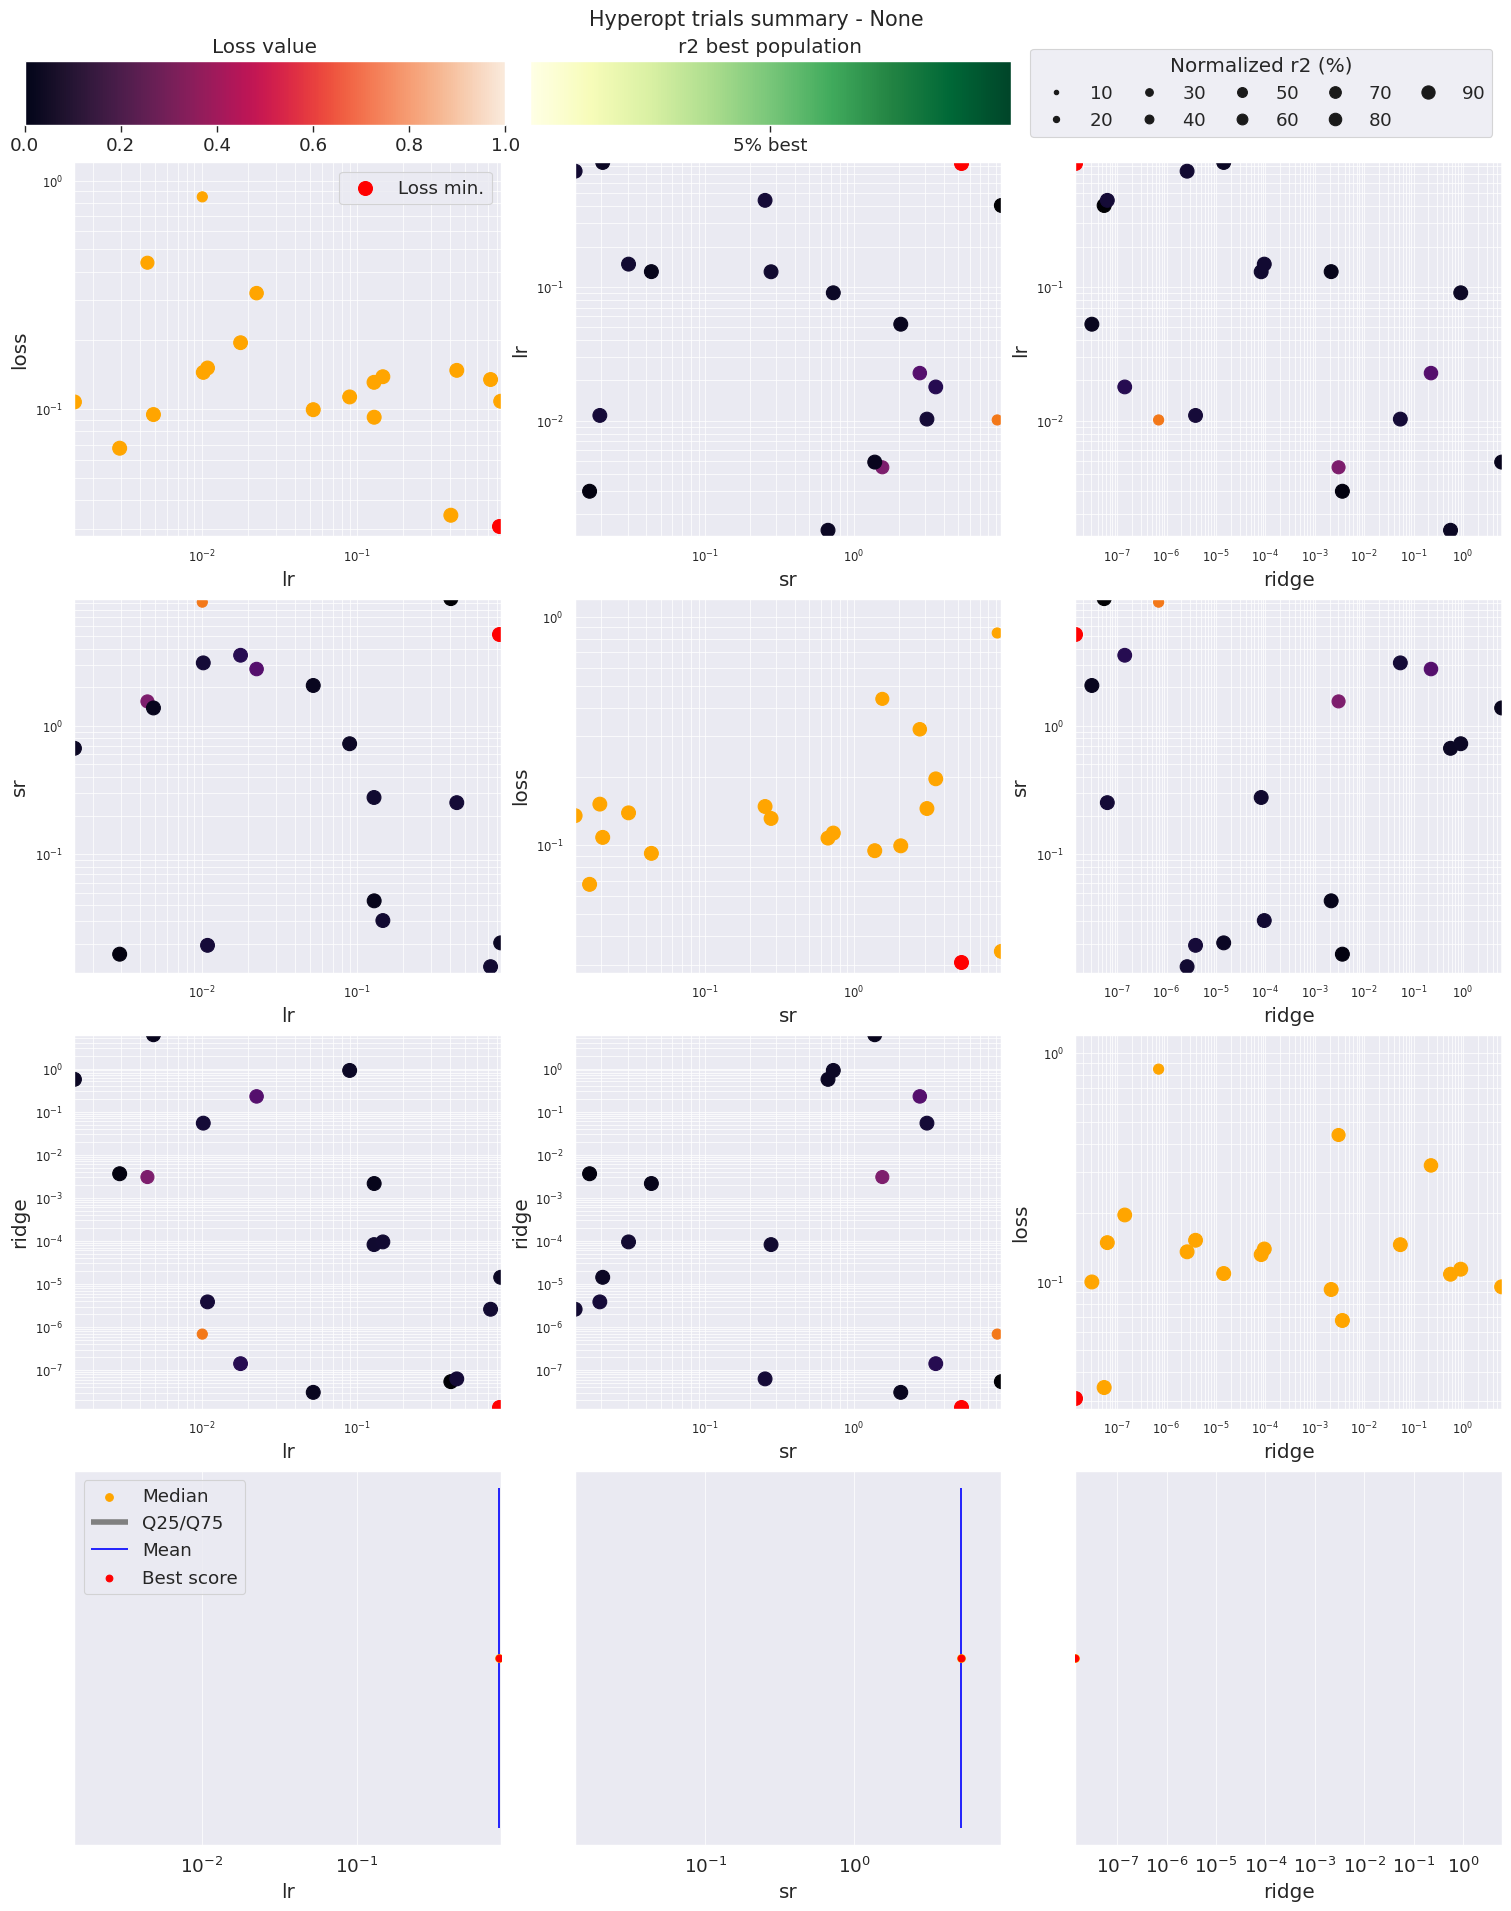

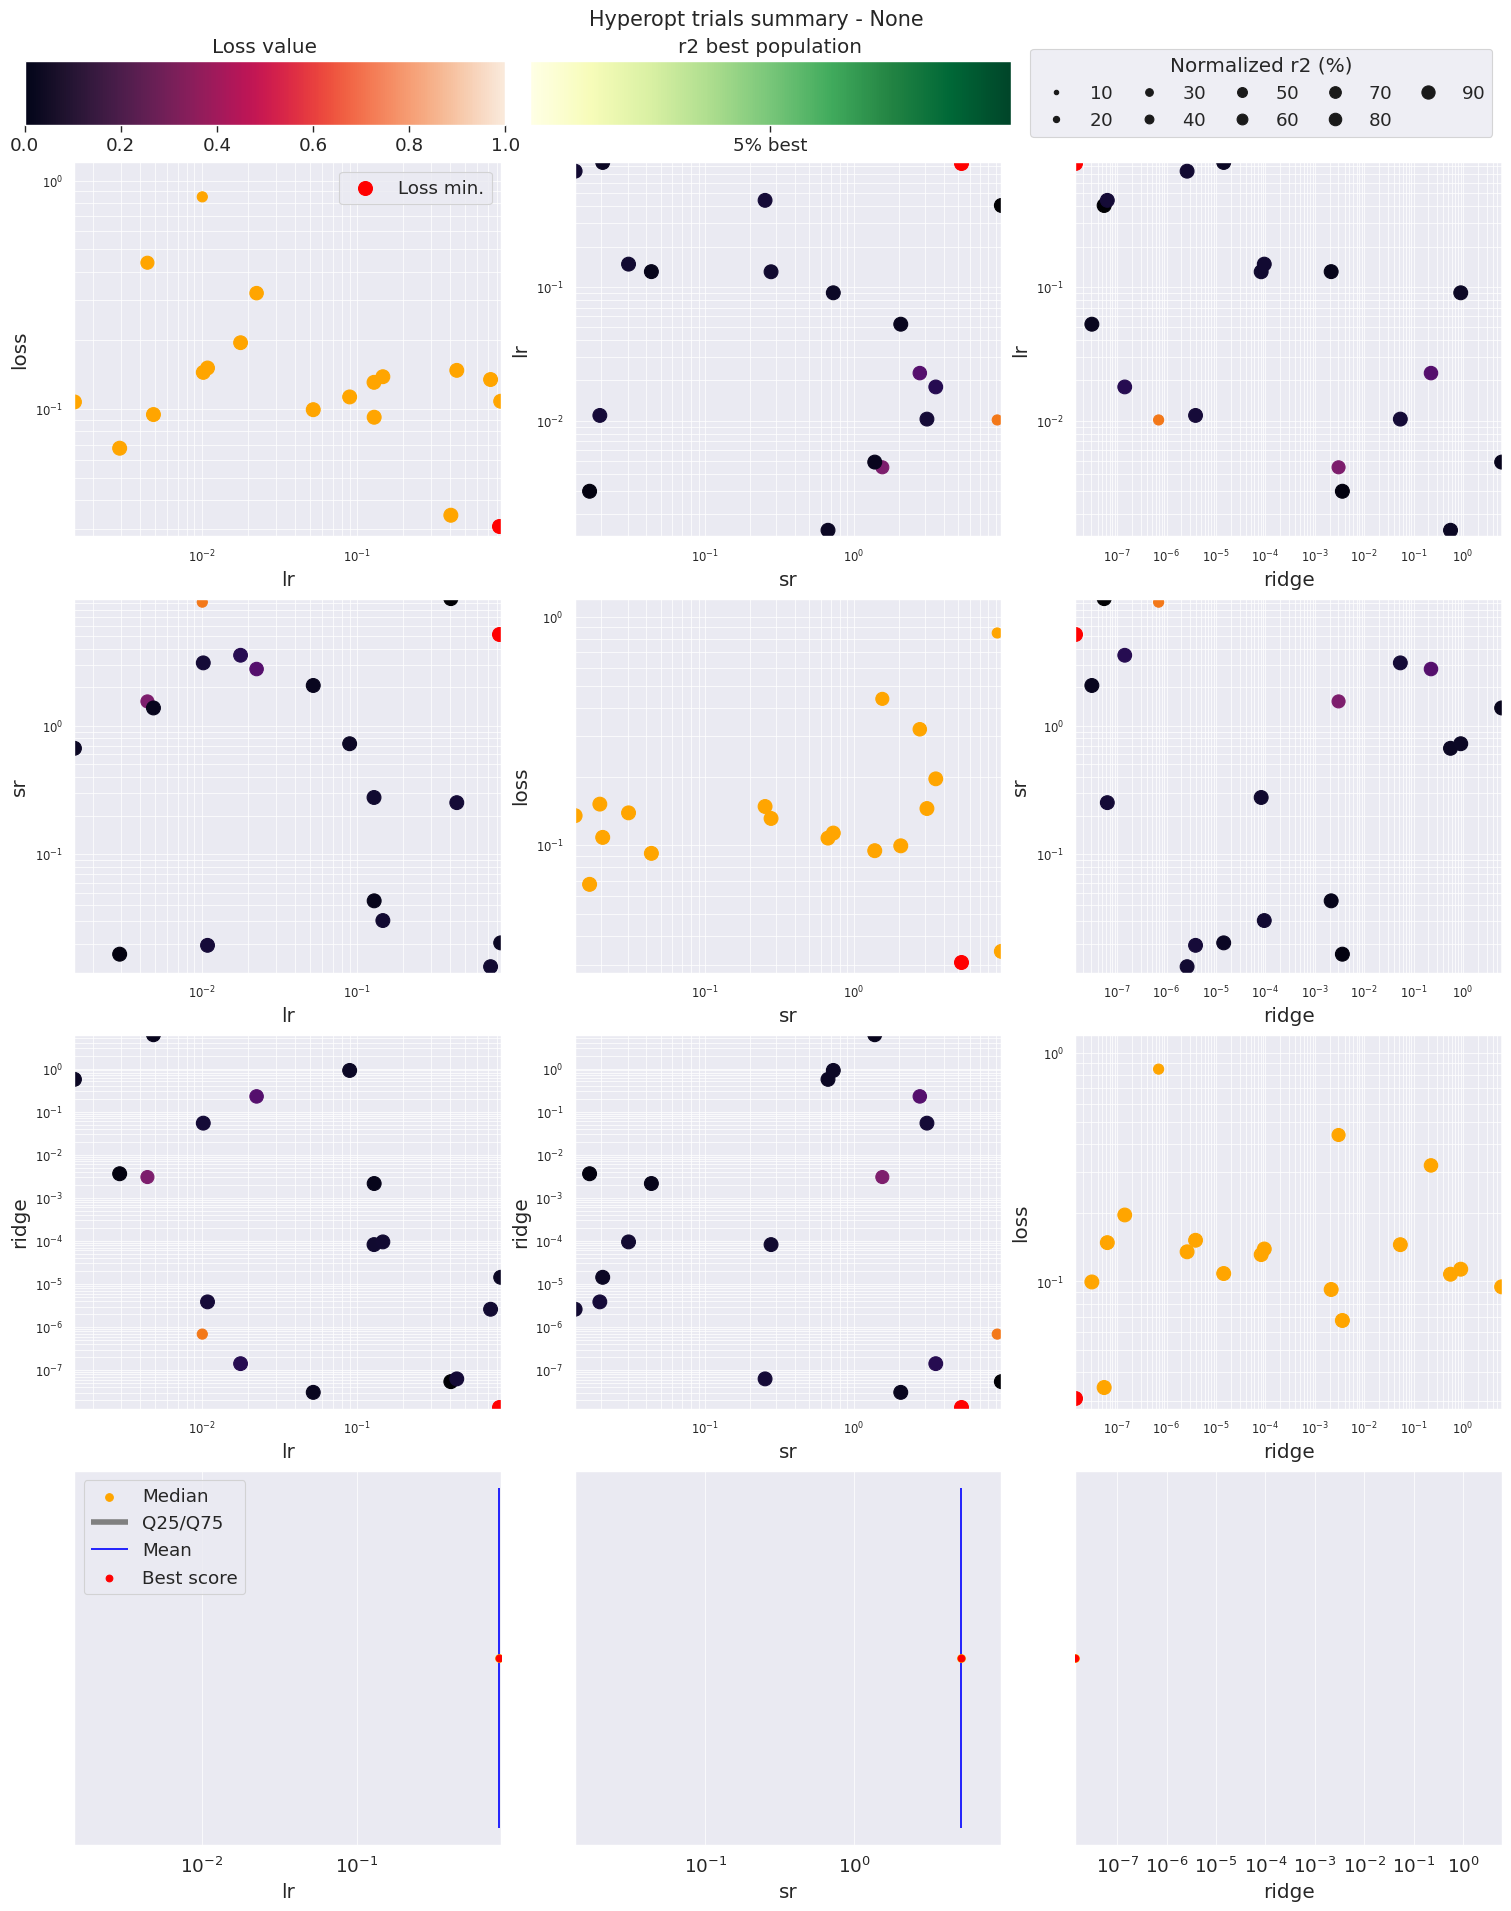

In [21]:
fig = plot_hyperopt_report(hyperopt_config["exp"], ("lr", "sr", "ridge"), metric="r2")
fig

## Prediction with best params on train dataset (checking the ability to train)

In [31]:
best[0]["input_to_readout"]

np.int64(0)

In [24]:
best_models = []

for variable_seed in range(
    best[0]["seed"], best[0]["seed"] + hyperopt_config["instances_per_trial"]
):

    input_kwargs = {}
    reservoir_kwargs = {
        "units": best[0]["N"],
        "lr": best[0]["lr"],
        "sr": best[0]["sr"],
        "input_scaling": best[0]["input_scaling"],
        "seed": variable_seed,
    }
    ridge_kwargs = {"ridge": best[0]["ridge"]}
    fit_kwargs = {"warmup": best[0]["warmup"]}

    model = ModelConfiguration(
        input_kwargs,
        reservoir_kwargs,
        ridge_kwargs,
        fit_kwargs,
        input_to_readout=best[0]["input_to_readout"],
        readout_feedback_to_reservoir=best[0]["readout_feedback_to_reservoir"],
    )

    model.fit(x_train_3D, y_train_3D)
    best_models.append(model)

In [25]:
list_y_hat_3D = [model.run(x_train_3D) for model in best_models]

In [26]:
list_rmse = [nrmse(y_train_3D, y_hat_3D) for y_hat_3D in list_y_hat_3D]
list_rmse

[np.float64(0.027199998797366013),
 np.float64(0.02785893646743199),
 np.float64(0.027807569479976278),
 np.float64(0.027253234904687302),
 np.float64(0.027210861576798865)]

In [27]:
idx_best_model = list_rmse.index(min(list_rmse))
y_hat_3D = list_y_hat_3D[idx_best_model]

y_hat_scaled = np.array(y_hat_3D).reshape(
    [N_series_train * N_times_train, len(y_labels)]
)

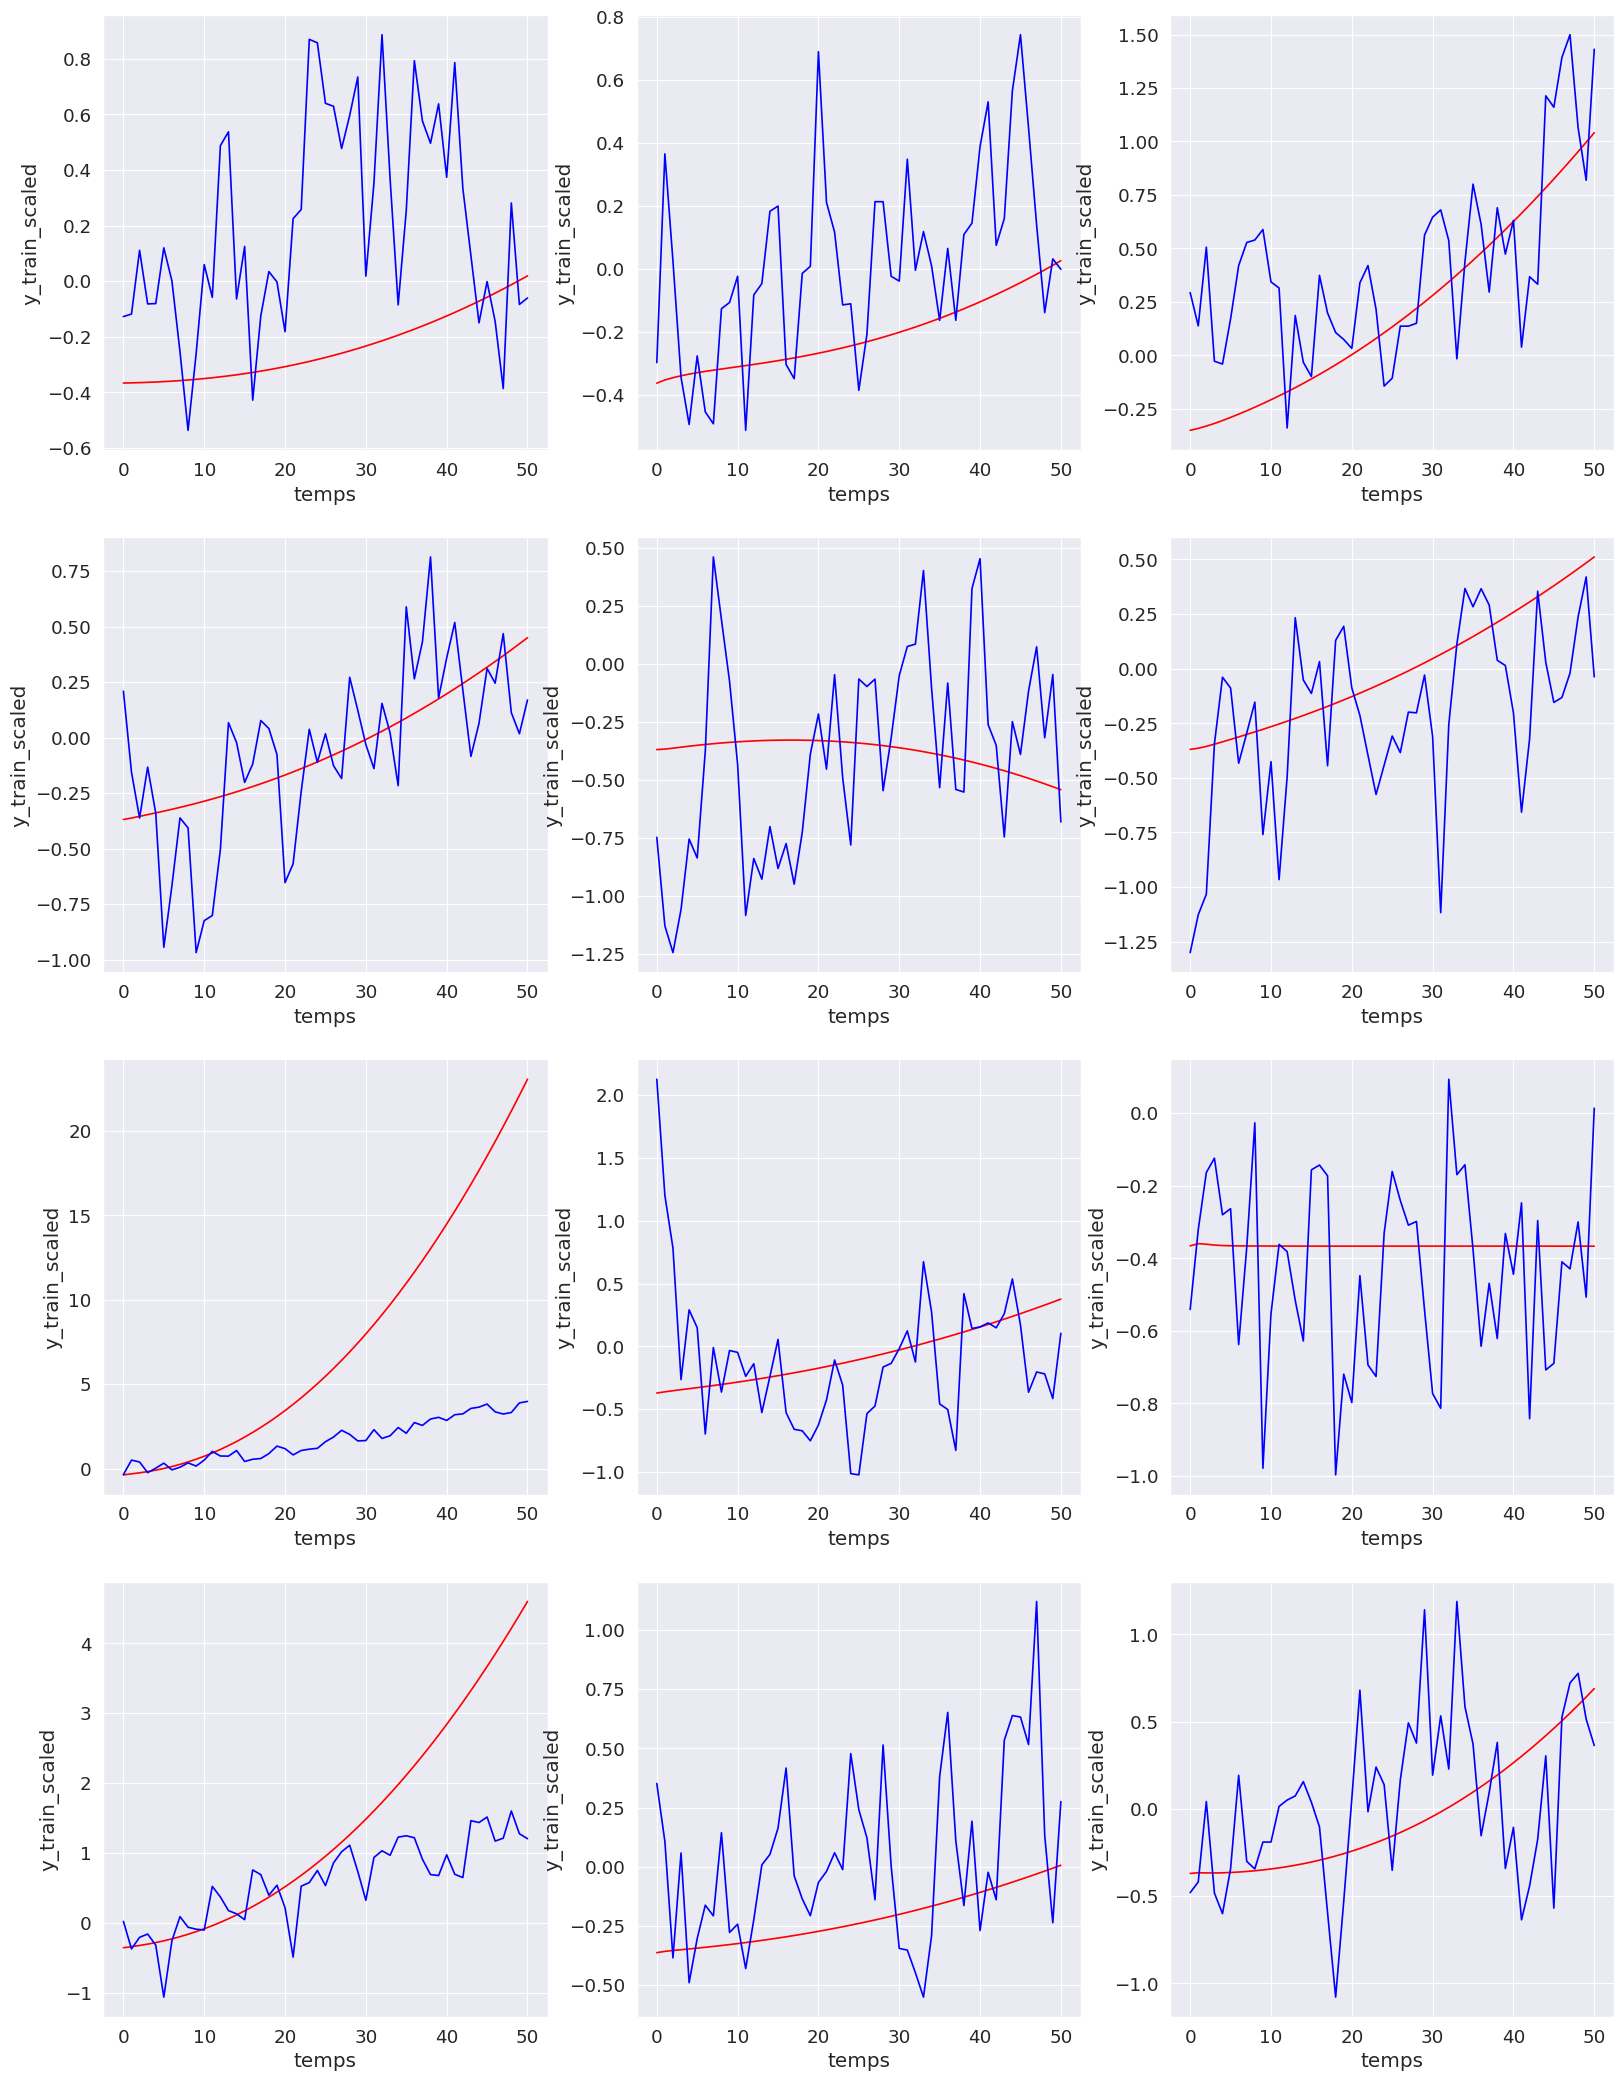

In [28]:
data_train["y_train_scaled"] = y_train_scaled
data_train["y_hat_scaled"] = y_hat_scaled
series_train = data_train[SERIE_COLUMN_NAME].unique()[:12]


NCOLS = 3
nrows = ceil(len(series_train) / NCOLS)


f, ax = plt.subplots(
    nrows=nrows,
    ncols=NCOLS,
    figsize=(6.5 * NCOLS, 6.5 * nrows),
)

for i_serie, serie in enumerate(series_train):
    irow = i_serie // NCOLS
    icol = i_serie % NCOLS
    data_plot = data_train[data_train[SERIE_COLUMN_NAME] == serie]

    sns.lineplot(
        x=data_plot[TIMESTEP_COLUMN_NAME],
        y=data_plot["y_train_scaled"],
        ax=ax[irow, icol],
        color="red",
    )
    sns.lineplot(
        x=data_plot[TIMESTEP_COLUMN_NAME],
        y=data_plot["y_hat_scaled"],
        ax=ax[irow, icol],
        color="blue",
    )